#### Load Data using numpy library

In [346]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

fields = ['Name','Team','Position','Cost','Creativity','Influence','Threat','ICT','Goals_conceded','Goals_scored','Assists','Own_goals','Penalties_missed','Penalties_saved','Saves','Yellow_cards','Red_cards','TSB','Minutes','Bonus','Points']
fpl_base_data = pd.read_csv('input_data/fpl/fpl_1.csv', skipinitialspace=True, usecols=fields)
fpl_base_data.head(5)

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Own_goals,Penalties_missed,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,0,0,6,0,0.3,2067,3,56
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0,0,0,69,2,0,0.6,1710,5,72
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0,0,0,0,2,0,12.6,1960,22,169
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0,0,0,0,5,0,5.7,3352,8,102
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,0,0,5,1,1.1,2533,12,107


#### Data Preprocessing

1. The feature "Name" is broken into "First Name and Last Name" based on space. From the data it is observed that most player last name is present in this data set.
2. All unique team names are fetched as this is required for data enrichment.

In [347]:
fpl_base_data[['first_name','last_name']] = fpl_base_data['Name'].loc[fpl_base_data['Name'].str.split().str.len() == 2].str.split(expand=True)
fpl_base_data.last_name.fillna(fpl_base_data.Name, inplace=True)
fpl_base_data.head(5)

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,first_name,last_name
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,6,0,0.3,2067,3,56,Adam,Smith
1,Adrian,WHU,GKP,45,0.0,470.4,0.0,47.0,29,0,...,0,69,2,0,0.6,1710,5,72,NaN,Adrian
2,Aguero,MCI,FWD,110,570.8,966.4,1484.0,302.5,12,21,...,0,0,2,0,12.6,1960,22,169,NaN,Aguero
3,Ake,BOU,DEF,50,115.1,932.4,287.0,133.5,59,2,...,0,0,5,0,5.7,3352,8,102,NaN,Ake
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,5,1,1.1,2533,12,107,NaN,Albrighton


In [348]:
fpl_base_data.Team.unique()

array(['BOU', 'WHU', 'MCI', 'LEI', 'TOT', 'LIV', 'CHE', 'BHA', 'SOU',
       'NEW', 'ARS', 'FUL', 'HUD', 'MUN', 'EVE', 'CAR', 'BUR', 'WOL',
       'CRY', 'WAT'], dtype=object)

#### Data Enrichment and Latent Manifold

1. From the web page https://www.transfermarkt.co.uk scraped team-wise player age and market value
2. Used BeautifulSoup as the html scraper
3. Found the table contents and scraped the age and market value for each player.
4. Stored this in fpl_3.csv file
5. Merged the base data with this new data based on player last name
6. Found some special characters in player name as this is scraped from web. Hence, performed manual cleaning of this to remove special characters and fetch the appropriate last name.
7. After enrichment, the data needed some cleaning. Price had to be stripped off the symbols and converted to float. Age had both date of birth and age. Performed string operations to only extract age and strip of the other characters.
8. Age can be a factor that influences user game. Hence we are considering this as a latent variable in our dataset.

In [355]:
url_list = {"BOU":"https://www.transfermarkt.co.uk/afc-bournemouth/kader/verein/989/saison_id/2018",
            "BHA":"https://www.transfermarkt.co.uk/brighton-amp-hove-albion/kader/verein/1237/saison_id/2018",
            "ARS":"https://www.transfermarkt.co.uk/arsenal-fc/kader/verein/11/saison_id/2018",
            "WHU":"https://www.transfermarkt.co.uk/west-ham-united/kader/verein/379/saison_id/2018",
            "MCI":"https://www.transfermarkt.co.uk/manchester-city/kader/verein/281/saison_id/2018",
            "LEI":"https://www.transfermarkt.co.uk/leicester-city/kader/verein/1003/saison_id/2018",
            "TOT":"https://www.transfermarkt.co.uk/tottenham-hotspur/kader/verein/148/saison_id/2018",
            "LIV":"https://www.transfermarkt.co.uk/fc-liverpool/kader/verein/31/saison_id/2018",
            "CHE":"https://www.transfermarkt.co.uk/fc-chelsea/kader/verein/631/saison_id/2018",
            "SOU":"https://www.transfermarkt.co.uk/fc-southampton/kader/verein/180/saison_id/2018",
            "FUL":"https://www.transfermarkt.co.uk/fc-fulham/kader/verein/931/saison_id/2018",
            "HUD":"https://www.transfermarkt.co.uk/huddersfield-town/kader/verein/1110/saison_id/2018",
            "MUN":"https://www.transfermarkt.co.uk/manchester-united/kader/verein/985/saison_id/2018",
            "EVE":"https://www.transfermarkt.co.uk/fc-everton/kader/verein/29/saison_id/2018",
            "CAR":"https://www.transfermarkt.co.uk/cardiff-city/kader/verein/603/saison_id/2018",
            "BUR":"https://www.transfermarkt.co.uk/fc-burnley/kader/verein/1132/saison_id/2018",
            "WOL":"https://www.transfermarkt.co.uk/wolverhampton-wanderers/kader/verein/543/saison_id/2018",
            "WAT":"https://www.transfermarkt.co.uk/fc-watford/kader/verein/1010/saison_id/2018",
            "NEW":"https://www.transfermarkt.co.uk/newcastle-united/kader/verein/762/saison_id/2018",
            "CRY":"https://www.transfermarkt.co.uk/crystal-palace/kader/verein/873/saison_id/2018"}

#### Web Scraper to fetch Player Age and Market Value

In [361]:
import requests
from bs4 import BeautifulSoup

def extract_player_age_market_value():
    player_details = []
    for team_name, request_url in url_list.items():
        page = requests.get(request_url, headers={'User-Agent': 'Mozilla/5.0'})
        soup = BeautifulSoup(page.text, "html.parser")
        for div in soup.find_all(name="div", attrs={"class":"row"}):
            for tab in div.find_all(name="table", attrs={"class":"items"}):
                for tr in tab.find_all(name="tr", attrs={"class":{"odd","even"}}):
                    a = tr.find_all(name="a", attrs={"class":"spielprofil_tooltip"})
                    player_details.append({'Name':a[0].contents[0], 'Age':tr.contents[3].text, 'Market_Value':tr.contents[6].text, 'Team': team_name})
    player_details = pd.DataFrame(player_details)
    return(player_details)

In [362]:
all_team_details = extract_player_age_market_value()
all_team_details.to_csv('input_data/fpl/fpl_3.csv'.format(os.getcwd()))

#### Data Cleaning

- The enriched data has to be cleaned to convert market value to number, age to number. Also, manually cleaned the names as it contained special characters.

In [366]:
all_team_details = pd.read_csv('input_data/fpl/fpl_3.csv', skipinitialspace=True, usecols=['Age', 'Market_Value', 'Name', 'Team'])
all_team_details.head(5)
all_team_details[['first_name','last_name']] = all_team_details['Name'].loc[all_team_details['Name'].str.split().str.len() == 2].str.split(expand=True)
all_team_details.last_name.fillna(all_team_details.Name, inplace=True)
print(all_team_details['Name'].count())

518


In [367]:
fpl_df = pd.merge(fpl_base_data,all_team_details[['last_name','Team', 'Age', 'Market_Value']], on=['last_name', 'Team'], how='left')

In [368]:
fpl_df = fpl_df.drop_duplicates(subset=['Name'])
fpl_df = fpl_df.drop(columns=['first_name', 'last_name'])
fpl_df = fpl_df[fpl_df['Market_Value'].notnull()]
fpl_df = fpl_df[fpl_df['Age'].notnull()]
print(fpl_df['Name'].count())

365


In [369]:
fpl_df['Market_Value'] = fpl_df['Market_Value'].astype(str)
fpl_df['Market_Value'] = fpl_df['Market_Value'].str.replace("£", "")
fpl_df['Market_Value'] = fpl_df['Market_Value'].str.replace("m", "")
fpl_df['Market_Value'] = fpl_df['Market_Value'].str.replace("k\xa0\xa0", "")
fpl_df['Market_Value'] = fpl_df['Market_Value'].astype(float)
fpl_df.head(5)

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,Age,Market_Value
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,6,0,0.3,2067,3,56,"Apr 29, 1991 (27)",4.5
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,5,1,1.1,2533,12,107,"Nov 18, 1989 (28)",9.0
5,Alderweireld,TOT,DEF,60,67.8,249.2,50.0,36.8,13,0,...,0,0,3,0,3.6,1177,3,43,"Mar 2, 1989 (29)",36.0
6,Alexander-Arnold,LIV,DEF,50,399.2,358.2,142.0,90.1,17,1,...,0,0,3,0,16.8,1573,10,83,"Oct 7, 1998 (20)",22.5
7,Alisson,LIV,GKP,55,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,8.8,0,0,0,"Oct 2, 1992 (26)",54.0


In [370]:
fpl_df['Age'] = fpl_df['Age'].astype(str).str.split(' ').str[-1]
fpl_df['Age'] = fpl_df['Age'].str.replace("(", "")
fpl_df['Age'] = fpl_df['Age'].str.replace(")", "")
fpl_df['Age'] = fpl_df['Age'].astype(int)
fpl_df.head()

,Name,Team,Position,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,...,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,Age,Market_Value
0,Adam Smith,BOU,DEF,45,345.5,455.0,144.0,94.5,38,1,...,0,0,6,0,0.3,2067,3,56,27,4.5
4,Albrighton,LEI,MID,55,718.3,580.0,300.0,160.2,42,2,...,0,0,5,1,1.1,2533,12,107,28,9.0
5,Alderweireld,TOT,DEF,60,67.8,249.2,50.0,36.8,13,0,...,0,0,3,0,3.6,1177,3,43,29,36.0
6,Alexander-Arnold,LIV,DEF,50,399.2,358.2,142.0,90.1,17,1,...,0,0,3,0,16.8,1573,10,83,20,22.5
7,Alisson,LIV,GKP,55,0.0,0.0,0.0,0.0,0,0,...,0,0,0,0,8.8,0,0,0,26,54.0


#### Data Description

In [371]:
fpl_df.describe()

,Cost,Creativity,Influence,Threat,ICT,Goals_conceded,Goals_scored,Assists,Own_goals,Penalties_missed,Penalties_saved,Saves,Yellow_cards,Red_cards,TSB,Minutes,Bonus,Points,Age,Market_Value
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,53.794521,200.145753,320.655342,218.756164,73.934521,19.260274,1.915068,1.695890,0.052055,0.046575,0.046575,4.128767,2.106849,0.076712,3.231507,1342.328767,4.682192,57.983562,27.021918,58.782329
std,13.053103,248.682774,290.172050,322.593233,75.189692,16.746680,3.846065,2.666048,0.287137,0.247005,0.278379,18.894658,2.411530,0.286376,5.856688,1085.385406,6.106908,52.002533,4.008173,182.325148
min,40.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,1.350000
25%,45.000000,0.000000,30.800000,0.000000,5.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,180.000000,0.000000,7.000000,24.000000,4.500000
50%,50.000000,104.500000,285.800000,99.000000,62.700000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.900000,1327.000000,2.000000,55.000000,27.000000,9.000000
75%,55.000000,311.100000,506.800000,299.000000,115.200000,30.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,3.500000,2184.000000,7.000000,89.000000,30.000000,22.500000
max,130.000000,1487.000000,1496.200000,2355.000000,454.400000,62.000000,32.000000,17.000000,4.000000,2.000000,3.000000,137.000000,11.000000,2.000000,47.500000,3420.000000,31.000000,303.000000,39.000000,900.000000


#### Co-relation Heat Map
- Draw co-relation heatmap to understand the corelation between various fetaures. From the below we can interpret that Points, ICT (influence, creativity and threat factor) and Cost are highly co-related. 

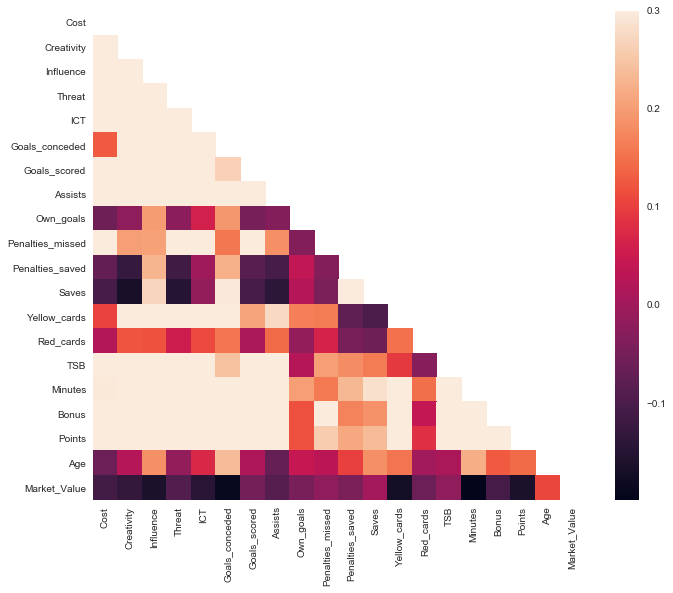

In [372]:
sns.set(style='white')
corr = fpl_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, vmax=.3)

#### Pairplot 

- Pairplot between all columns to identify the relationship

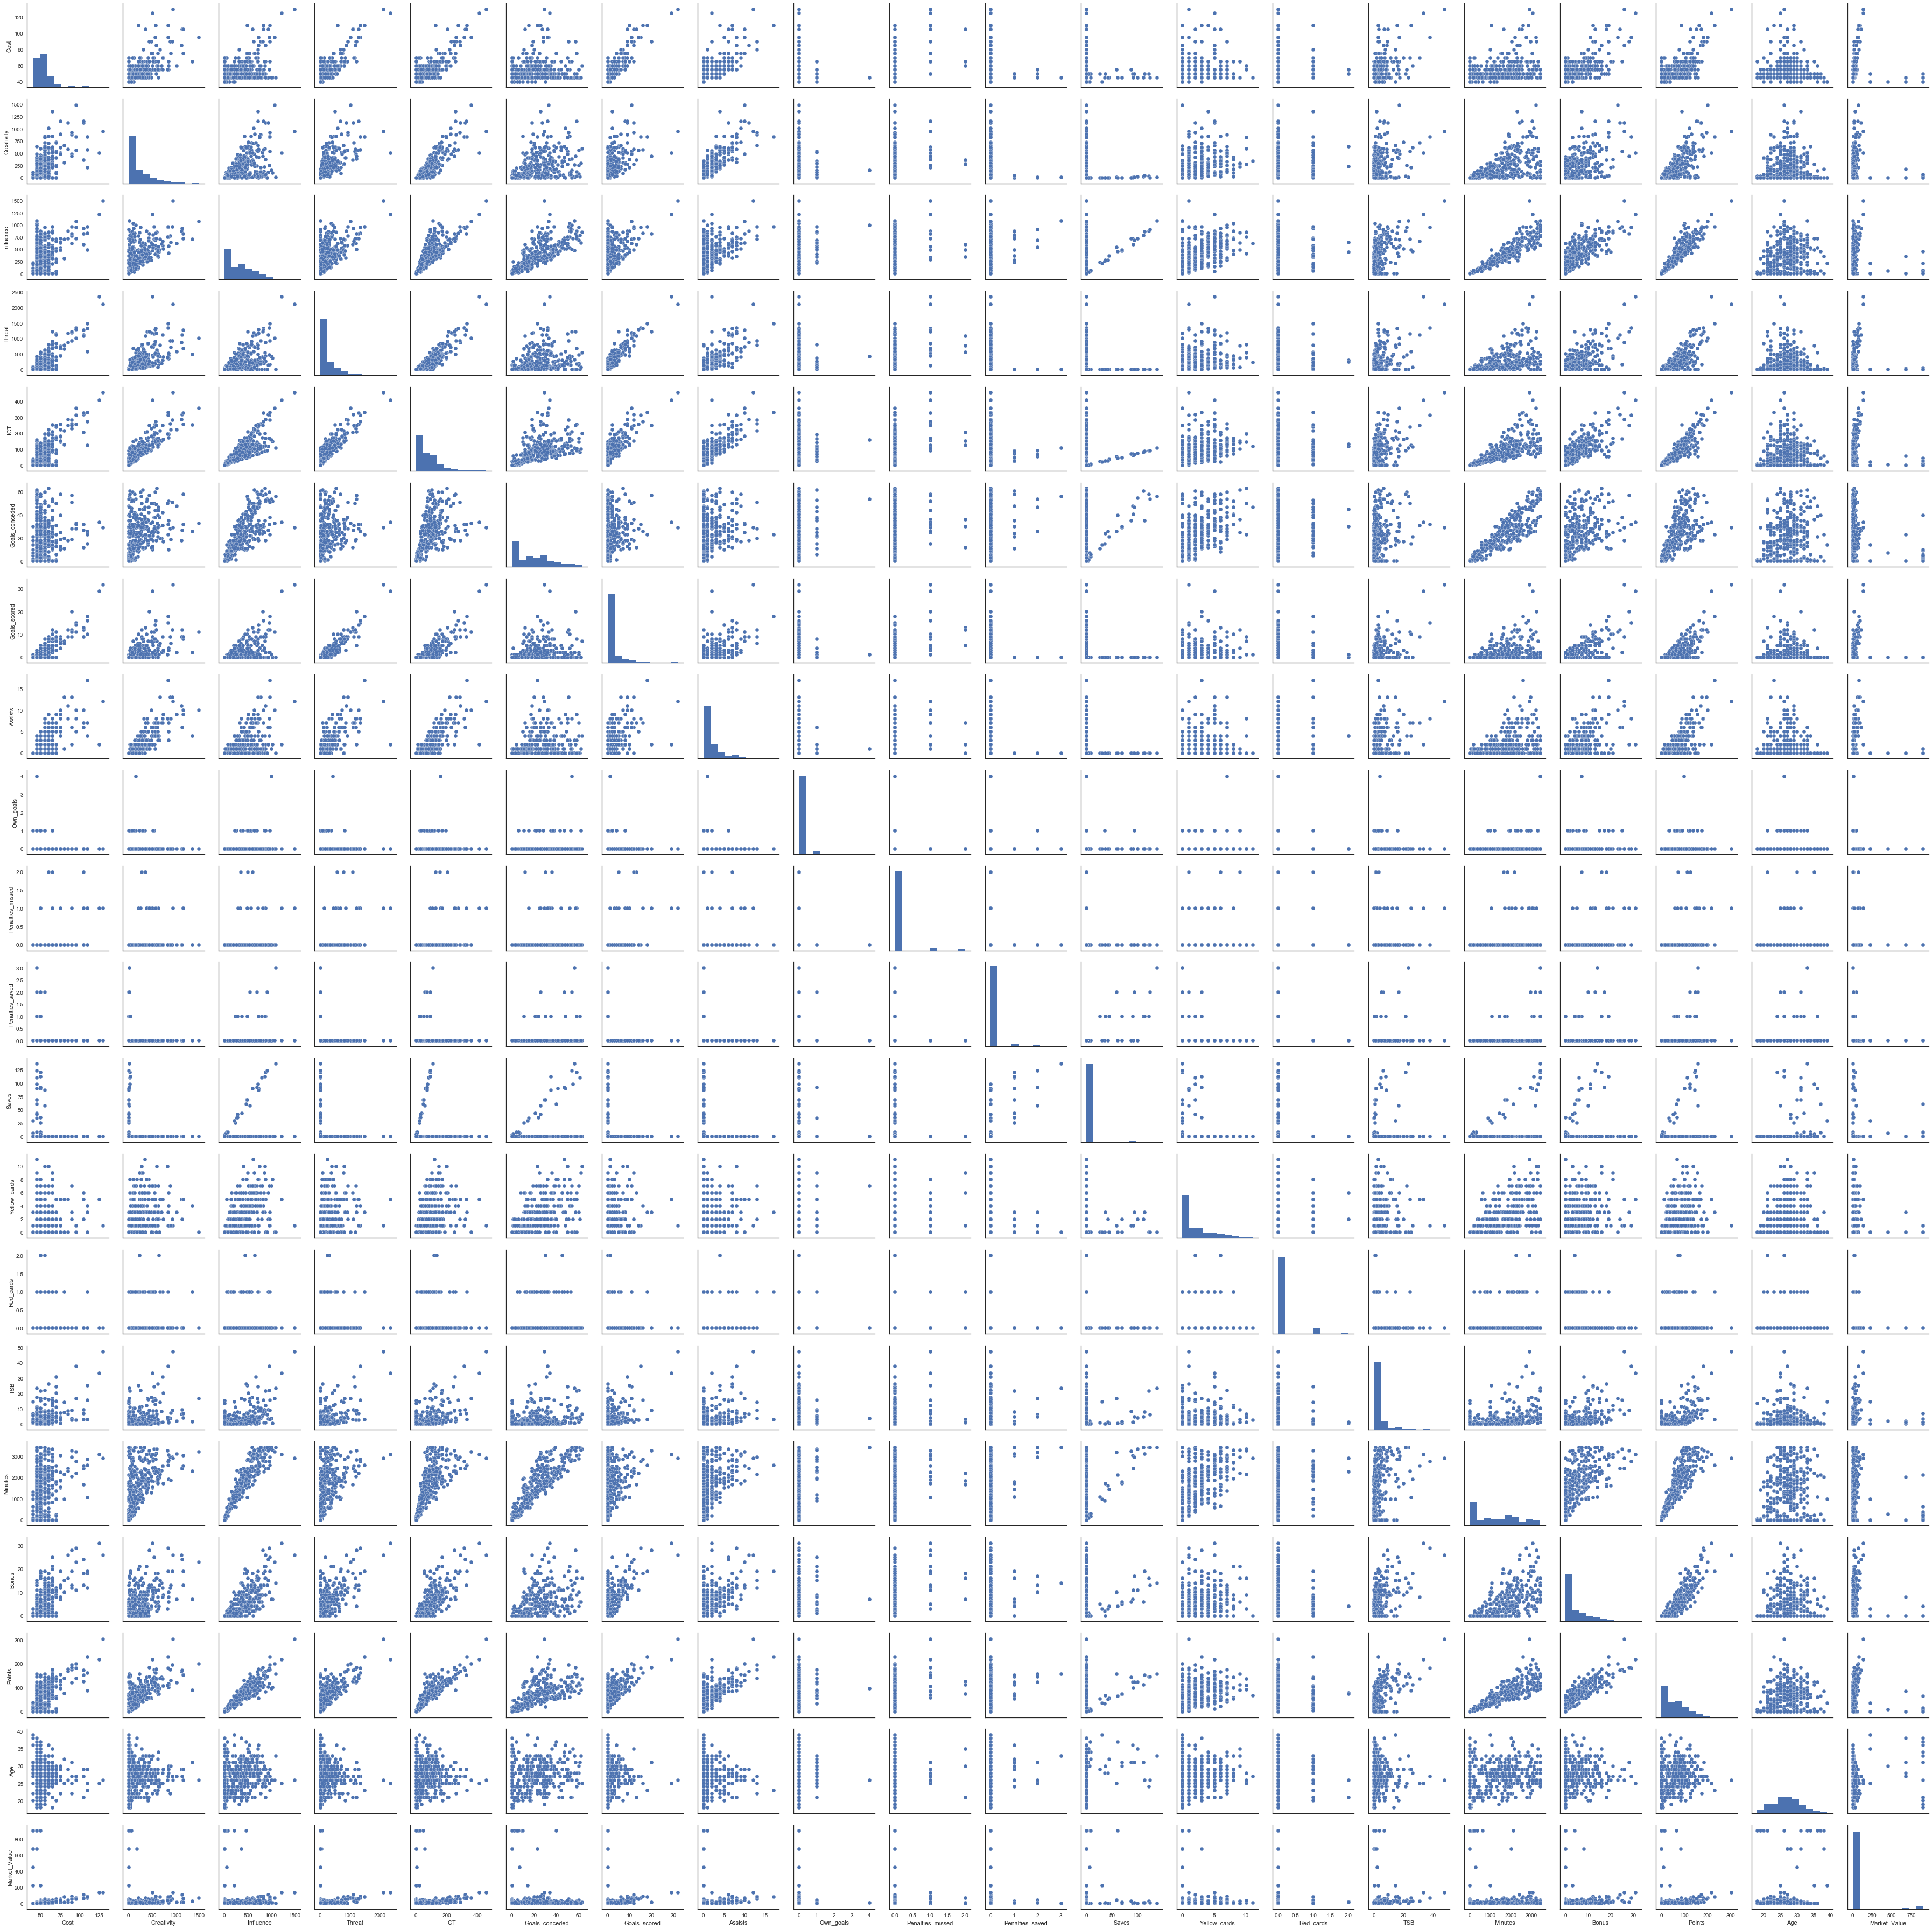

In [332]:
sns.pairplot(fpl_df)

#### Clustering

Applying KMeans clustering to understand how players can be grouped based on ICT value. ICT is a factor of influence, creativity and threat. The points scored by each player is a result of ICT. From the below KMeans application we can group the players as 2 clusters. Low ICT and High ICT

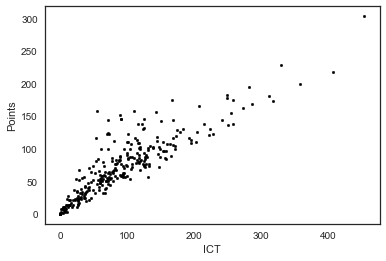

In [373]:
f1 = fpl_df['ICT'].values
f2 = fpl_df['Points'].values

plt.xlabel('ICT')
plt.ylabel('Points')
plt.scatter(f1, f2, c='black', s=7)
plt.show()

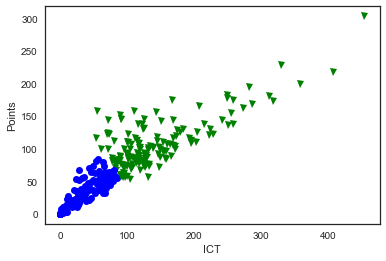

In [374]:
from sklearn.cluster import KMeans

M=np.matrix(list(zip(f1, f2)))
kmeans = KMeans(n_clusters=2).fit(M)
#centers = kmeans.cluster_centers_
y_pred = kmeans.predict(M)

colors = ['b', 'g', 'm', 'y', 'c']
markers = ['o', 'v', 'x', 'o', 's']
#center_colors = colors[:len(y_pred)]

plt.xlabel('ICT')
plt.ylabel('Points')
for i, l in enumerate(kmeans.labels_):
    plt.plot(f1[i], f2[i], color=colors[l], marker=markers[l],ls='None')

#### Gaussian Mixture Model

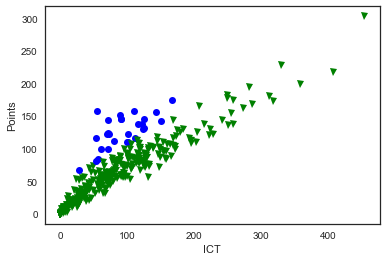

In [375]:
import warnings
from sklearn.mixture import GMM

warnings.filterwarnings("ignore", category=DeprecationWarning)

M=np.matrix(list(zip(f1, f2)))
gmm = GMM(n_components=2,  covariance_type='tied', random_state=0).fit(M)
labels = gmm.predict(M)

plt.xlabel('ICT')
plt.ylabel('Points')

for i, l in enumerate(labels):
    plt.plot(f1[i], f2[i], color=colors[l], marker=markers[l],ls='None')

#### Linear Regression

Applying linear regression on ICT and Points to predict the points player might score

In [376]:
X = fpl_df[['ICT']]
y = fpl_df[['Points']]

In [377]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Split X and y into X_
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_model.score(X_test, y_test)

0.8372021600475203

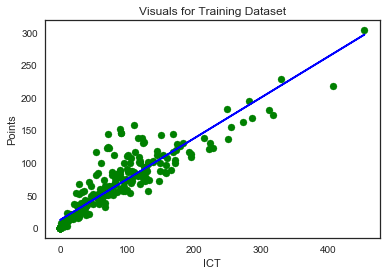

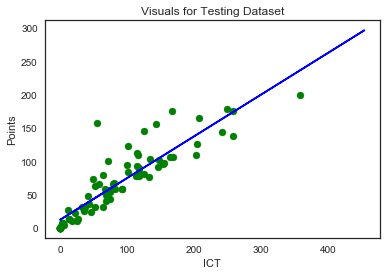

In [378]:
y_pred = regression_model.predict(X_test) 

#Visualizing the training Test Results 
plt.scatter(X_train, y_train, color= 'green')
plt.plot(X_train, regression_model.predict(X_train), color = 'blue')
plt.title ("Visuals for Training Dataset")
plt.xlabel("ICT")
plt.ylabel("Points")
plt.show()

#Visualizing the Test Results 
plt.scatter(X_test, y_test, color= 'green')
plt.plot(X_train, regression_model.predict(X_train), color = 'blue')
plt.title ("Visuals for Testing Dataset")
plt.xlabel("ICT")
plt.ylabel("Points")
plt.show()